In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import tempfile
import os
from models.normalizing_flow import HierarchicalNormalizingFlowSB
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn


In [3]:
from train_flow_sb import unflatten, object_from_config

In [4]:
api = wandb.Api()

In [5]:
# run = api.run('druhe/gw-src/ntnb1v04')
run = api.run('druhe/gw-src/2k062zzd')



In [6]:
config = unflatten(run.config)

In [7]:
dataset = object_from_config(config, key='dataset')
dataset = dataset(**config['dataset'])

In [8]:
flows = object_from_config(config, key='flow')(**config['flow'])

In [9]:
checkpoints = [f for f in run.files() if f.name.endswith('.ckpt')]

In [10]:
tempdir = tempfile.TemporaryDirectory()

In [11]:
ckpt = checkpoints[-1]

In [12]:
ckpt_path = ckpt.download(root=tempdir.name, replace=True)

In [13]:
model = object_from_config(config, key='model')

In [14]:
model = model.load_from_checkpoint(ckpt_path.name, flows=flows, dataset=dataset)




INFO:torch.distributed.nn.jit.instantiator:Created a temporary directory at /var/folders/d3/x840qlg17x1f92cnsrkq62fw0000gn/T/tmp3_puib44
INFO:torch.distributed.nn.jit.instantiator:Writing /var/folders/d3/x840qlg17x1f92cnsrkq62fw0000gn/T/tmp3_puib44/_remote_module_non_sriptable.py


In [15]:
import hamiltorch

from torch.nn.utils import _stateless


In [16]:
def flatten_params(parameters):
    """
    flattens all parameters into a single column vector. Returns the dictionary to recover them
    :param: parameters: a generator or list of all the parameters
    :return: a dictionary: {"params": [#params, 1],
    "indices": [(start index, end index) for each param] **Note end index in uninclusive**

    """
    l = [torch.flatten(p) for p in parameters]
    indices = []
    s = 0
    for p in l:
        size = p.shape[0]
        indices.append((s, s+size))
        s += size
    flat = torch.cat(l).view(-1, 1)
    return flat, indices


def unflatten_params(flat_params, indices, model):
    """
    Gives a list of recovered parameters from their flattened form
    :param flat_params: [#params, 1]
    :param indices: a list detaling the start and end index of each param [(start, end) for param]
    :param model: the model that gives the params with correct shapes
    :return: the params, reshaped to the ones in the model, with the same order as those in the model
    """
    l = [flat_params[s:e] for (s, e) in indices]
    for i, p in enumerate(model.parameters()):
        l[i] = l[i].view(*p.shape)
    return tuple(nn.Parameter(p) for p in l)


In [17]:
params_flat, indices = flatten_params(model.parameters())
names = list(n for n, _ in model.named_parameters())


In [18]:
model=model.double()

params_init = hamiltorch.util.flatten(model).clone().double()


In [19]:
gw_loader = dataset.train_dataloader()

In [20]:
gw_iter = iter(gw_loader)

In [21]:
def log_prob(params, y=None):
    global gw_iter
    global sel_iter
    try:
        gw_batch = next(gw_iter)
#         sel_batch = next(sel_iter)
    except StopIteration:
        gw_iter = iter(gw_loader)
#         sel_iter = iter(sel_loader)
        gw_batch = next(gw_iter)
#         sel_batch = next(sel_iter)

    gw_batch[0] = gw_batch[0].double()
#     sel_batch[0] = sel_batch[0].double()
    
    prior = torch.distributions.Normal(params_init, 1).log_prob(params)

    params = unflatten_params(params, indices, model)
            
    out: torch.Tensor = _stateless.functional_call(model, {n: p for n, p in zip(names, params)}, gw_batch)    
    ll = prior.sum() / len(out) + out.mean()
#     print(out.mean().item())
    return ll




In [22]:
N = 1024
burn = 256
N_nuts = N + burn
step_size = 1e-3
L = 20

samples = hamiltorch.sample(
    log_prob, 
    params_init=params_init, 
    num_samples=N_nuts, 
    num_steps_per_sample=L, 
    step_size=step_size, 
    burn=burn, 
    desired_accept_rate=0.8,
    sampler=hamiltorch.Sampler.HMC_NUTS,
    debug=True)

Sampling (Sampler.HMC; Integrator.IMPLICIT)
Time spent  | Time remain.| Progress             | Samples   | Samples/sec
Step: 0, Current Hamiltoninian: 43.33570503867048, Proposed Hamiltoninian: 49.00105657254768
REJECT
Step: 1, Current Hamiltoninian: 56.55307212690671, Proposed Hamiltoninian: 116.39309935301458
REJECT
Step: 2, Current Hamiltoninian: 53.03877126144934, Proposed Hamiltoninian: 63.896832619443195
REJECT
Step: 3, Current Hamiltoninian: 47.466802696185965, Proposed Hamiltoninian: 47.54347053110905
REJECT
Step: 4, Current Hamiltoninian: 56.23007988335888, Proposed Hamiltoninian: 56.216336286646126
Accept rho: 0.0
Step: 5, Current Hamiltoninian: 55.23726759155247, Proposed Hamiltoninian: 55.3535865383899
Accept rho: -0.11631894683743127
Step: 6, Current Hamiltoninian: 51.70197671349852, Proposed Hamiltoninian: 51.817995064379915
Accept rho: -0.11601835088139723
Step: 7, Current Hamiltoninian: 52.11743304455517, Proposed Hamiltoninian: 52.136979659008304
Accept rho: -0.0195466

Step: 71, Current Hamiltoninian: 49.253718515465344, Proposed Hamiltoninian: 49.05792835708553
Accept rho: 0.0
Step: 72, Current Hamiltoninian: 55.84097086302088, Proposed Hamiltoninian: 56.076821323580944
Accept rho: -0.23585046056006576
Step: 73, Current Hamiltoninian: 54.107928082516736, Proposed Hamiltoninian: 54.36863588524023
Accept rho: -0.2607078027234948
Step: 74, Current Hamiltoninian: 49.52720102329104, Proposed Hamiltoninian: 49.45958333200298
Accept rho: 0.0
Step: 75, Current Hamiltoninian: 52.480846874909446, Proposed Hamiltoninian: 52.786944900026796
Accept rho: -0.3060980251173504
Step: 76, Current Hamiltoninian: 43.52690404577156, Proposed Hamiltoninian: 43.58068991052226
Accept rho: -0.053785864750700796
Step: 77, Current Hamiltoninian: 48.00079364835935, Proposed Hamiltoninian: 48.02803926080305
Accept rho: -0.02724561244369994
Step: 78, Current Hamiltoninian: 52.50823751406921, Proposed Hamiltoninian: 55.34485262446378
REJECT
Step: 79, Current Hamiltoninian: 50.9452

Step: 144, Current Hamiltoninian: 55.22686726535063, Proposed Hamiltoninian: 57.46016049007145
REJECT
Step: 145, Current Hamiltoninian: 50.19434718751894, Proposed Hamiltoninian: 49.56210433416416
Accept rho: 0.0
Step: 146, Current Hamiltoninian: 58.73007934586492, Proposed Hamiltoninian: 57.835794198119586
Accept rho: 0.0
Step: 147, Current Hamiltoninian: 50.44448473413428, Proposed Hamiltoninian: 53.949889222891755
REJECT
Step: 148, Current Hamiltoninian: 59.02247688998263, Proposed Hamiltoninian: 58.61690383918598
Accept rho: 0.0
Step: 149, Current Hamiltoninian: 58.41640712509671, Proposed Hamiltoninian: 56.966439431870036
Accept rho: 0.0
Step: 150, Current Hamiltoninian: 62.75843366664864, Proposed Hamiltoninian: 62.20077653870476
Accept rho: 0.0
Step: 151, Current Hamiltoninian: 51.642670056905956, Proposed Hamiltoninian: 51.99512606121189
Accept rho: -0.35245600430593527
Step: 152, Current Hamiltoninian: 47.48705566402526, Proposed Hamiltoninian: 46.64767383554034
Accept rho: 0.

Step: 216, Current Hamiltoninian: 55.54570994861811, Proposed Hamiltoninian: 56.60119658280361
REJECT
Step: 217, Current Hamiltoninian: 69.22728213018834, Proposed Hamiltoninian: 67.91291413999133
Accept rho: 0.0
Step: 218, Current Hamiltoninian: 51.2717817915629, Proposed Hamiltoninian: 51.59074716767951
Accept rho: -0.31896537611660847
Step: 219, Current Hamiltoninian: 48.21873186374237, Proposed Hamiltoninian: 48.740680308568734
REJECT
Step: 220, Current Hamiltoninian: 54.29147722930591, Proposed Hamiltoninian: 52.83337990683518
Accept rho: 0.0
Step: 221, Current Hamiltoninian: 67.65466668974678, Proposed Hamiltoninian: 70.20248684451781
REJECT
Step: 222, Current Hamiltoninian: 58.722310994092545, Proposed Hamiltoninian: 58.62200309752458
Accept rho: 0.0
Step: 223, Current Hamiltoninian: 57.35697902224188, Proposed Hamiltoninian: 58.23852209854585
REJECT
Step: 224, Current Hamiltoninian: 42.565776073670996, Proposed Hamiltoninian: 40.92141165277245
Accept rho: 0.0
Step: 225, Current

Step: 289, Current Hamiltoninian: 57.202406567461985, Proposed Hamiltoninian: 60.58549599969079
REJECT
Step: 290, Current Hamiltoninian: 50.04120210170893, Proposed Hamiltoninian: 48.10101665478891
Accept rho: 0.0
Step: 291, Current Hamiltoninian: 61.15723378329628, Proposed Hamiltoninian: 58.28257764948447
Accept rho: 0.0
Step: 292, Current Hamiltoninian: 46.05971935127198, Proposed Hamiltoninian: 45.32648562329684
Accept rho: 0.0
Step: 293, Current Hamiltoninian: 58.473282033203304, Proposed Hamiltoninian: 56.21616149885776
Accept rho: 0.0
Step: 294, Current Hamiltoninian: 59.08777237005714, Proposed Hamiltoninian: 58.01129764766547
Accept rho: 0.0
Step: 295, Current Hamiltoninian: 64.08842893459462, Proposed Hamiltoninian: 61.28416361520786
Accept rho: 0.0
Step: 296, Current Hamiltoninian: 42.23932696057731, Proposed Hamiltoninian: 45.26159734091269
REJECT
Step: 297, Current Hamiltoninian: 53.484507815600296, Proposed Hamiltoninian: 52.41637943955725
Accept rho: 0.0
Step: 298, Curre

Step: 363, Current Hamiltoninian: 55.00585226232823, Proposed Hamiltoninian: 55.07725587107193
Accept rho: -0.07140360874369378
Step: 364, Current Hamiltoninian: 66.87075851032357, Proposed Hamiltoninian: 69.41198922225763
REJECT
Step: 365, Current Hamiltoninian: 53.22449855257685, Proposed Hamiltoninian: 50.28967549649284
Accept rho: 0.0
Step: 366, Current Hamiltoninian: 54.52055534473298, Proposed Hamiltoninian: 53.01825277490031
Accept rho: 0.0
Step: 367, Current Hamiltoninian: 55.06571083655763, Proposed Hamiltoninian: 55.349410770415794
Accept rho: -0.2836999338581663
Step: 368, Current Hamiltoninian: 58.40339331327565, Proposed Hamiltoninian: 56.939872401019
Accept rho: 0.0
Step: 369, Current Hamiltoninian: 66.56484596269172, Proposed Hamiltoninian: 64.4728211994064
Accept rho: 0.0
Step: 370, Current Hamiltoninian: 68.96395301151104, Proposed Hamiltoninian: 69.76360203544917
REJECT
Step: 371, Current Hamiltoninian: 58.973590140409115, Proposed Hamiltoninian: 57.79963318646959
Acc

Step: 436, Current Hamiltoninian: 61.313267362777154, Proposed Hamiltoninian: 62.6150567205551
REJECT
Step: 437, Current Hamiltoninian: 64.78435171357076, Proposed Hamiltoninian: 63.95870809642376
Accept rho: 0.0
Step: 438, Current Hamiltoninian: 50.217470863801815, Proposed Hamiltoninian: 49.48364127282029
Accept rho: 0.0
Step: 439, Current Hamiltoninian: 55.38198548326436, Proposed Hamiltoninian: 52.90563480821324
Accept rho: 0.0
Step: 440, Current Hamiltoninian: 60.07331314099459, Proposed Hamiltoninian: 59.96024771138867
Accept rho: 0.0
Step: 441, Current Hamiltoninian: 56.2195794484409, Proposed Hamiltoninian: 56.219138369503355
Accept rho: 0.0
Step: 442, Current Hamiltoninian: 67.04562611055682, Proposed Hamiltoninian: 68.07929601578972
REJECT
Step: 443, Current Hamiltoninian: 46.495639960025954, Proposed Hamiltoninian: 48.89984641725117
REJECT
Step: 444, Current Hamiltoninian: 48.62864271353748, Proposed Hamiltoninian: 46.67765356694322
Accept rho: 0.0
Step: 445, Current Hamilto

Step: 509, Current Hamiltoninian: 58.642945966199164, Proposed Hamiltoninian: 55.688968765734025
Accept rho: 0.0
Step: 510, Current Hamiltoninian: 54.32898571683495, Proposed Hamiltoninian: 56.724617727476115
REJECT
Step: 511, Current Hamiltoninian: 47.569112357924936, Proposed Hamiltoninian: 46.40994816629728
Accept rho: 0.0
Step: 512, Current Hamiltoninian: 45.56326130979363, Proposed Hamiltoninian: 44.834144071223655
Accept rho: 0.0
Step: 513, Current Hamiltoninian: 52.75341485024062, Proposed Hamiltoninian: 53.85433877553019
REJECT
Step: 514, Current Hamiltoninian: 59.982845989256106, Proposed Hamiltoninian: 60.86620013532801
REJECT
Step: 515, Current Hamiltoninian: 58.81810241916924, Proposed Hamiltoninian: 58.63205591655239
Accept rho: 0.0
Step: 516, Current Hamiltoninian: 60.43423342510105, Proposed Hamiltoninian: 58.973118405692084
Accept rho: 0.0
Step: 517, Current Hamiltoninian: 48.71523642056599, Proposed Hamiltoninian: 47.25307850774383
Accept rho: 0.0
Step: 518, Current Ha

Step: 583, Current Hamiltoninian: 60.138324213941715, Proposed Hamiltoninian: 58.372740853197676
Accept rho: 0.0
Step: 584, Current Hamiltoninian: 61.71920096743102, Proposed Hamiltoninian: 62.82295393678989
REJECT
Step: 585, Current Hamiltoninian: 54.001473974971226, Proposed Hamiltoninian: 53.304864898056415
Accept rho: 0.0
Step: 586, Current Hamiltoninian: 49.72853793845402, Proposed Hamiltoninian: 48.6017628144998
Accept rho: 0.0
Step: 587, Current Hamiltoninian: 56.22448669691374, Proposed Hamiltoninian: 58.13199608835079
REJECT
Step: 588, Current Hamiltoninian: 58.38251814523789, Proposed Hamiltoninian: 57.981765520521414
Accept rho: 0.0
Step: 589, Current Hamiltoninian: 48.96173400779119, Proposed Hamiltoninian: 52.306537609133414
REJECT
Step: 590, Current Hamiltoninian: 60.22704821281534, Proposed Hamiltoninian: 60.15844924985598
Accept rho: 0.0
Step: 591, Current Hamiltoninian: 55.20478099490276, Proposed Hamiltoninian: 54.782227059838895
Accept rho: 0.0
Step: 592, Current Ham

Step: 657, Current Hamiltoninian: 46.26714413943128, Proposed Hamiltoninian: 49.36141756269225
REJECT
Step: 658, Current Hamiltoninian: 62.92669270921273, Proposed Hamiltoninian: 62.4924210972759
Accept rho: 0.0
Step: 659, Current Hamiltoninian: 52.791248751058006, Proposed Hamiltoninian: 53.82029312129371
REJECT
Step: 660, Current Hamiltoninian: 64.15174446065966, Proposed Hamiltoninian: 63.167990507588925
Accept rho: 0.0
Step: 661, Current Hamiltoninian: 55.98910983554535, Proposed Hamiltoninian: 55.36241227190286
Accept rho: 0.0
Step: 662, Current Hamiltoninian: 59.19519755845679, Proposed Hamiltoninian: 61.405083504500254
REJECT
Step: 663, Current Hamiltoninian: 58.30656606072264, Proposed Hamiltoninian: 57.41943908945813
Accept rho: 0.0
Step: 664, Current Hamiltoninian: 60.84400643594472, Proposed Hamiltoninian: 61.0690810930803
Accept rho: -0.22507465713557906
Step: 665, Current Hamiltoninian: 60.99259597756834, Proposed Hamiltoninian: 60.63757622250699
Accept rho: 0.0
Step: 666,

Step: 731, Current Hamiltoninian: 68.65951612018362, Proposed Hamiltoninian: 65.26370649856236
Accept rho: 0.0
Step: 732, Current Hamiltoninian: 64.65040911556932, Proposed Hamiltoninian: 62.23026240831311
Accept rho: 0.0
Step: 733, Current Hamiltoninian: 53.136140003607665, Proposed Hamiltoninian: 53.73909479086018
Accept rho: -0.6029547872525143
Step: 734, Current Hamiltoninian: 67.02705046953244, Proposed Hamiltoninian: 68.07263012383191
Accept rho: -1.0455796542994733
Step: 735, Current Hamiltoninian: 71.01548920888773, Proposed Hamiltoninian: 69.94940337436175
Accept rho: 0.0
Step: 736, Current Hamiltoninian: 54.11121833318655, Proposed Hamiltoninian: 54.40853179864818
Accept rho: -0.2973134654616274
Step: 737, Current Hamiltoninian: 57.91050043437059, Proposed Hamiltoninian: 58.93796809647579
REJECT
Step: 738, Current Hamiltoninian: 78.10572481928081, Proposed Hamiltoninian: 76.18077300014144
Accept rho: 0.0
Step: 739, Current Hamiltoninian: 55.469027347715766, Proposed Hamiltoni

Step: 804, Current Hamiltoninian: 65.63754008641675, Proposed Hamiltoninian: 62.75308258851535
Accept rho: 0.0
Step: 805, Current Hamiltoninian: 51.350233413877795, Proposed Hamiltoninian: 51.47242522652418
Accept rho: -0.12219181264638479
Step: 806, Current Hamiltoninian: 66.06696467133015, Proposed Hamiltoninian: 65.05443195719053
Accept rho: 0.0
Step: 807, Current Hamiltoninian: 51.66768220081468, Proposed Hamiltoninian: 51.57539634518935
Accept rho: 0.0
Step: 808, Current Hamiltoninian: 60.735666314248775, Proposed Hamiltoninian: 61.58632488952718
Accept rho: -0.8506585752784019
Step: 809, Current Hamiltoninian: 57.76132897727666, Proposed Hamiltoninian: 56.73896630719908
Accept rho: 0.0
Step: 810, Current Hamiltoninian: 69.02098147176034, Proposed Hamiltoninian: 71.22297421176927
REJECT
Step: 811, Current Hamiltoninian: 59.93077342394882, Proposed Hamiltoninian: 59.92613230619611
Accept rho: 0.0
Step: 812, Current Hamiltoninian: 54.93319230073125, Proposed Hamiltoninian: 55.338377

Step: 878, Current Hamiltoninian: 52.5928128278483, Proposed Hamiltoninian: 53.532636540043775
REJECT
Step: 879, Current Hamiltoninian: 61.48408223279799, Proposed Hamiltoninian: 62.742727145187445
REJECT
Step: 880, Current Hamiltoninian: 54.83940146398171, Proposed Hamiltoninian: 54.730628664819875
Accept rho: 0.0
Step: 881, Current Hamiltoninian: 58.41105675890468, Proposed Hamiltoninian: 58.02230695106699
Accept rho: 0.0
Step: 882, Current Hamiltoninian: 62.125154599441935, Proposed Hamiltoninian: 64.03861322099573
REJECT
Step: 883, Current Hamiltoninian: 44.83253503837481, Proposed Hamiltoninian: 45.63719709011135
REJECT
Step: 884, Current Hamiltoninian: 58.715471205804015, Proposed Hamiltoninian: 58.51319749474429
Accept rho: 0.0
Step: 885, Current Hamiltoninian: 54.332312130249555, Proposed Hamiltoninian: 52.62622556951085
Accept rho: 0.0
Step: 886, Current Hamiltoninian: 60.565156614926295, Proposed Hamiltoninian: 60.49275046483618
Accept rho: 0.0
Step: 887, Current Hamiltoninia

Step: 953, Current Hamiltoninian: 74.4245448387719, Proposed Hamiltoninian: 75.83535050255591
Accept rho: -1.4108056637840178
Step: 954, Current Hamiltoninian: 66.75142346663303, Proposed Hamiltoninian: 69.7393115842018
REJECT
Step: 955, Current Hamiltoninian: 61.70129432757598, Proposed Hamiltoninian: 63.00733061692331
REJECT
Step: 956, Current Hamiltoninian: 69.6937958485359, Proposed Hamiltoninian: 71.00574060651755
REJECT
Step: 957, Current Hamiltoninian: 49.71631625189917, Proposed Hamiltoninian: 48.55379350407905
Accept rho: 0.0
Step: 958, Current Hamiltoninian: 60.43310255824906, Proposed Hamiltoninian: 60.01094805874443
Accept rho: 0.0
Step: 959, Current Hamiltoninian: 47.18404647713173, Proposed Hamiltoninian: 46.95890750461891
Accept rho: 0.0
Step: 960, Current Hamiltoninian: 53.242647233434475, Proposed Hamiltoninian: 53.576462628164045
REJECT
Step: 961, Current Hamiltoninian: 51.39827456233287, Proposed Hamiltoninian: 48.73723496662126
Accept rho: 0.0
Step: 962, Current Ham

Step: 1026, Current Hamiltoninian: 61.56801743656833, Proposed Hamiltoninian: 61.37976864257654
Accept rho: 0.0
Step: 1027, Current Hamiltoninian: 47.95864949348896, Proposed Hamiltoninian: 46.62558423691438
Accept rho: 0.0
Step: 1028, Current Hamiltoninian: 59.403073609026755, Proposed Hamiltoninian: 59.193214503969145
Accept rho: 0.0
Step: 1029, Current Hamiltoninian: 50.54933017772383, Proposed Hamiltoninian: 50.46650559213212
Accept rho: 0.0
Step: 1030, Current Hamiltoninian: 49.82993066709084, Proposed Hamiltoninian: 50.303103380257554
Accept rho: -0.4731727131667114
Step: 1031, Current Hamiltoninian: 51.001616589013906, Proposed Hamiltoninian: 53.84590754701417
REJECT
Step: 1032, Current Hamiltoninian: 49.34541244851327, Proposed Hamiltoninian: 50.37086150661118
REJECT
Step: 1033, Current Hamiltoninian: 48.02821004647898, Proposed Hamiltoninian: 46.85166056232359
Accept rho: 0.0
Step: 1034, Current Hamiltoninian: 61.848209465175174, Proposed Hamiltoninian: 62.875445737121204
Acce

Step: 1098, Current Hamiltoninian: 50.33906175425288, Proposed Hamiltoninian: 52.32865942652714
REJECT
Step: 1099, Current Hamiltoninian: 60.450614764991016, Proposed Hamiltoninian: 62.54122172925402
REJECT
Step: 1100, Current Hamiltoninian: 60.241383018696126, Proposed Hamiltoninian: 60.24740558863416
Accept rho: -0.006022569938032518
Step: 1101, Current Hamiltoninian: 52.88722517946428, Proposed Hamiltoninian: 53.138171921753234
Accept rho: -0.25094674228895286
Step: 1102, Current Hamiltoninian: 62.00028893406604, Proposed Hamiltoninian: 61.907717573861646
Accept rho: 0.0
Step: 1103, Current Hamiltoninian: 57.9080340956015, Proposed Hamiltoninian: 53.00837054138633
Accept rho: 0.0
Step: 1104, Current Hamiltoninian: 60.32977706122915, Proposed Hamiltoninian: 62.78917717928424
REJECT
Step: 1105, Current Hamiltoninian: 46.82386933005462, Proposed Hamiltoninian: 47.01830916887608
Accept rho: -0.19443983882145943
Step: 1106, Current Hamiltoninian: 48.82417473775382, Proposed Hamiltoninian

Step: 1170, Current Hamiltoninian: 45.61333235827368, Proposed Hamiltoninian: 44.88638238902278
Accept rho: 0.0
Step: 1171, Current Hamiltoninian: 58.48942901499056, Proposed Hamiltoninian: 60.19508151279375
REJECT
Step: 1172, Current Hamiltoninian: 57.80507880389281, Proposed Hamiltoninian: 56.03778125483562
Accept rho: 0.0
Step: 1173, Current Hamiltoninian: 49.642229311138955, Proposed Hamiltoninian: 49.87318734757759
Accept rho: -0.23095803643863633
Step: 1174, Current Hamiltoninian: 61.775664058277805, Proposed Hamiltoninian: 62.49117321916782
Accept rho: -0.715509160890015
Step: 1175, Current Hamiltoninian: 58.13076313541294, Proposed Hamiltoninian: 58.35041201569791
Accept rho: -0.21964888028497143
Step: 1176, Current Hamiltoninian: 60.55270305332239, Proposed Hamiltoninian: 59.92437960679783
Accept rho: 0.0
Step: 1177, Current Hamiltoninian: 49.74985651604326, Proposed Hamiltoninian: 52.1204844376823
Accept rho: -2.3706279216390413
Step: 1178, Current Hamiltoninian: 61.833405164

Step: 1242, Current Hamiltoninian: 61.67290838395039, Proposed Hamiltoninian: 64.56035928187411
REJECT
Step: 1243, Current Hamiltoninian: 49.71979766426131, Proposed Hamiltoninian: 49.711689446649125
Accept rho: 0.0
Step: 1244, Current Hamiltoninian: 46.7643146086993, Proposed Hamiltoninian: 45.449073934806506
Accept rho: 0.0
Step: 1245, Current Hamiltoninian: 60.90105920297533, Proposed Hamiltoninian: 62.7046926589543
REJECT
Step: 1246, Current Hamiltoninian: 51.98487807948122, Proposed Hamiltoninian: 51.8634622007787
Accept rho: 0.0
Step: 1247, Current Hamiltoninian: 45.46131806052976, Proposed Hamiltoninian: 46.74058008008824
REJECT
Step: 1248, Current Hamiltoninian: 67.50869950977868, Proposed Hamiltoninian: 68.22813017507382
Accept rho: -0.7194306652951354
Step: 1249, Current Hamiltoninian: 55.5473179029236, Proposed Hamiltoninian: 55.27483980595517
Accept rho: 0.0
Step: 1250, Current Hamiltoninian: 52.82212120225108, Proposed Hamiltoninian: 53.72694342536093
Accept rho: -0.904822

In [23]:
samples = torch.stack(samples)

In [24]:
axes_names = []
axes = []

for n, ax in dataset.grid.items():
    axes_names.append(n)
    axes.append(ax)

d = dataset.dimensionality
m1, m2, z, chi = np.stack(np.meshgrid(*axes, indexing="ij")).reshape(d, -1)

resolutions = [len(ax) for ax in axes]

input = np.stack([m1, m2, z, chi], axis=-1)
input = torch.from_numpy(input)

In [25]:
def functional_call(model, flat_params):
    
    params = unflatten_params(flat_params, indices, model)

    out: torch.Tensor = _stateless.functional_call(model, {n: p for n, p in zip(names, params)}, input)    
    return out

In [26]:
with torch.no_grad():
    logprob = functional_call(model, params_init)
prob = logprob.exp().view(*resolutions)


In [27]:
pm1m2 = prob.sum((2, 3))

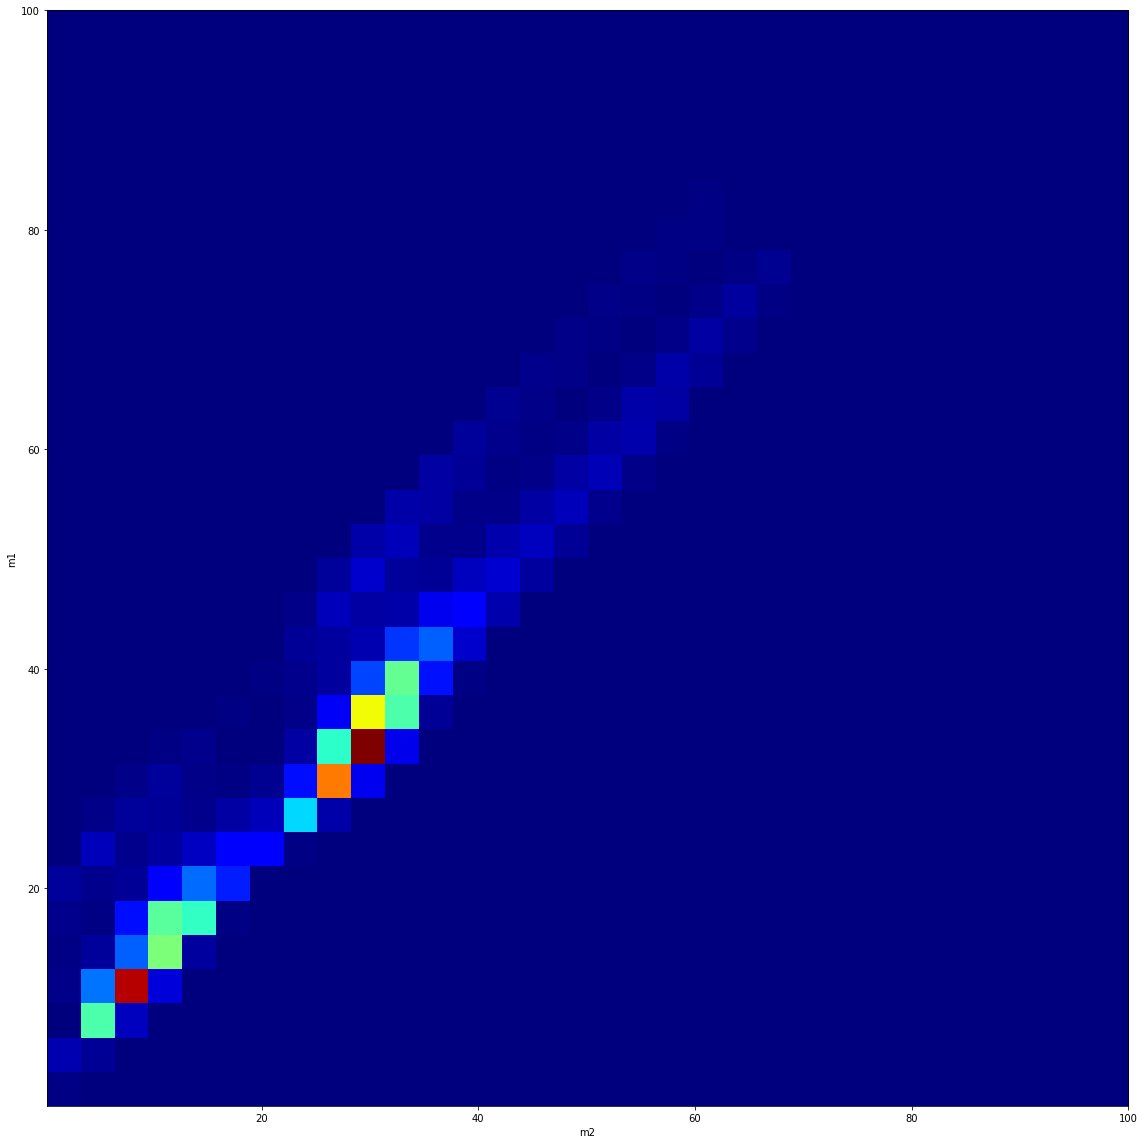

In [28]:
fig = plt.figure(figsize=(16, 16), facecolor="white")
plt.imshow(
    pm1m2,
    cmap="jet",
    origin="lower",
    extent=(
        axes[1][0],
        axes[1][-1],
        axes[0][0],
        axes[0][-1],
    ),  # origin='lower' changes the order
    aspect="auto",
)

plt.xlabel(axes_names[1])  # origin='lower' changes the order
plt.ylabel(axes_names[0])
plt.tight_layout()

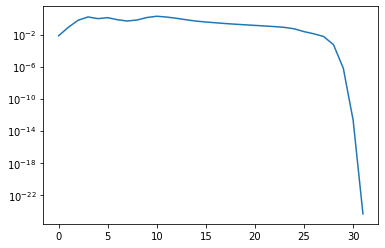

In [29]:
pm1= prob.sum((1, 2, 3))
plt.plot(pm1)
plt.yscale('log')

In [30]:
import tqdm

In [31]:
probs = []
for sample in tqdm.tqdm(samples):
    with torch.no_grad():
        logprob = functional_call(model, sample)
    prob = logprob.exp().view(*resolutions)
    probs.append(prob)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1024/1024 [13:28<00:00,  1.27it/s]


In [32]:
probs = torch.stack(probs)

In [33]:
probs.shape

torch.Size([1024, 32, 32, 32, 32])

In [34]:
m1 = probs.sum((2, 3, 4)).numpy()

In [35]:
m1_med = np.median(m1, axis=0)

In [36]:
m1_005 = np.percentile(m1, 5, axis=0)
m1_095 = np.percentile(m1, 95, axis=0)

(1e-05, 3)

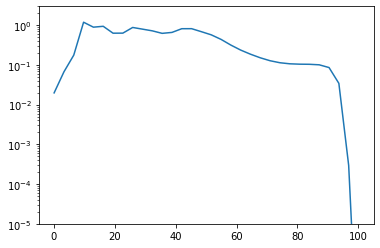

In [37]:
plt.plot(axes[0], m1_med)
plt.fill_between(axes[0], m1_005, m1_095, alpha=0.1)
plt.yscale('log')
plt.ylim((1e-5, 3))